## Practice with the Gensium Tutorial for LDA Topic Modeling

Topic modeling is a technique for taking some unstructured text and automatically extracting its common themes, it is a great way to get a bird's eye view on a large text collection. 

Gensim = “Generate Similar” is a popular open source natural language processing library used for unsupervised topic modeling.

Gensim uses top academic models and modern statistical machine learning to perform various complex tasks such as −

* Building document or word vectors
* Corpora
* Performing topic identification
* Performing document comparison (retrieving semantically similar documents)
* Analysing plain-text documents for semantic structure

However, unlike Scikit-Learn, Gensim doesn’t do any work on behalf of your documents for tokenization or stemming.

The Gensim library uses a popular algorithm for doing topic model, namely Latent Dirichlet Allocation. Latent Dirichlet Allocation (LDA). LDA requires documents to be represented as a bag of words (for the gensim library, some of the API calls will shorten it to "bow"). This representation ignores word ordering in the document but retains information on how many times each word appears.

The main distinguishing feature for LDA is it allows for mixed membership, which means that each document can partially belong to several different topics. Note that the vocabulary probability will sum up to 1 for every topic, but often times, words that have lower weights will be truncated from the output.

Text modified from: 
* <https://notebook.community/ethen8181/machine-learning/clustering/topic_model/LDA>
* <https://radimrehurek.com/gensim/auto_examples/core/run_core_concepts.html#sphx-glr-auto-examples-core-run-core-concepts-py>
* <https://www.tutorialspoint.com/gensim/index.htm>


In [1]:
## General Dependencies
import re
import numpy as np
import pandas as pd
from pprint import pprint
import sys, os
import glob
from tika import parser # pip install tika

## Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim import models
#from gensim.models.coherencemodel import CoherenceModel
from gensim.models import CoherenceModel
from gensim.models import LdaModel
from gensim.models.wrappers import LdaMallet

## Preprocessing
import spacy
import nltk as nltk
from nltk.stem import WordNetLemmatizer 
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

## Plotting
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt

## Other Libraries
from operator import itemgetter

## ScikitLearn
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

C:\Users\keg827\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backend_bases.py:55: DeprecationWarning: PILLOW_VERSION is deprecated and will be removed in a future release. Use __version__ instead.
  from PIL import PILLOW_VERSION
C:\Users\keg827\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backend_bases.py:55: DeprecationWarning: PILLOW_VERSION is deprecated and will be removed in a future release. Use __version__ instead.
  from PIL import PILLOW_VERSION
C:\Users\keg827\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
## Consider removing this code
## Import data on fetch 20 news groups
# from sklearn.datasets import fetch_20newsgroups
# newsgroups_train = fetch_20newsgroups(subset='train')
# data = newsgroups_train.data
# print(data[1])

In [3]:
## Use the glob method to retrieve files/pathnames in the directory
## https://www.geeksforgeeks.org/how-to-use-glob-function-to-find-files-recursively-in-python/

directory = "Test_Files/News_Industry"
files = list(glob.glob(os.path.join(directory,'*.*')))
print(files)

## Other Resources
## https://stackoverflow.com/questions/34000914/how-to-create-a-list-from-filenames-in-a-user-specified-directory-in-python
## https://stackoverflow.com/questions/3207219/how-do-i-list-all-files-of-a-directory
## https://stackoverflow.com/questions/33912773/python-read-txt-files-into-a-dataframe

['Test_Files/News_Industry\\Bibliography.10AGGRESSION AND PHYSICAL HEALTH IN MARRIED WOMEN.pdf', 'Test_Files/News_Industry\\Bibliography.12Impact of Socio-demographic Factors on Awareness of Smoking Effects on Oral Health among Smokers and.pdf', 'Test_Files/News_Industry\\Bibliography.17Health-Promoting Factors related to lifestyle among nursing students in University of Hail.pdf', 'Test_Files/News_Industry\\Bibliography.17Multinomial logit analysis of the effects of five different app-based incentives to encourage cyclin.pdf', 'Test_Files/News_Industry\\Bibliography.1PREVALENCE OF DYSLIPIDEMIA IN YOUNG ADULTS.pdf', 'Test_Files/News_Industry\\Bibliography.20Risk Factors for Atherosclerotic Cardiovascular Disease in the South Asian Population.pdf', 'Test_Files/News_Industry\\Bibliography.29Is the Gay Community the Neo-marginalised of Modern Society_.pdf', 'Test_Files/News_Industry\\Bibliography.33A Biological Effect of Sex Hormone Binding Globulin and Testosterone in Polycystic Ovary Sy

In [4]:
## Extract text from the pdfs and add them to a list using Tika Python
## The output is a dictionary with: metadata, content, status

document_list = []
for f in files:
    raw = parser.from_file(f)
    document_list.append(raw)
    
## Resources
## https://www.geeksforgeeks.org/parsing-pdfs-in-python-with-tika/
## https://stackoverflow.com/questions/34837707/how-to-extract-text-from-a-pdf-file

In [5]:
## Add the dictionary to a pandas dataframe

text_df = pd.DataFrame(document_list)
text_df.head()
## print(text_df["content"][1])
## text_df.to_csv('gensim_test.csv')

,metadata,content,status
0,"{'Content-Type': 'application/pdf', 'Creation-...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,200
1,"{'Content-Type': 'application/pdf', 'Creation-...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,200
2,"{'Content-Type': 'application/pdf', 'Creation-...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,200
3,"{'Content-Type': 'application/pdf', 'Creation-...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,200
4,"{'Content-Type': 'application/pdf', 'Creation-...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,200


In [72]:
## Create a new column in the dataframe called "title" and populate it with the title from the metadata key called dc:title

text_df['title'] = [value.get('dc:title') for value in text_df["metadata"]]

text_df.head()

## Resources
## https://stackoverflow.com/questions/44218812/pandas-add-columns-to-a-dataframe-based-in-dict-from-one-of-the-columns

## If needed, you can review the contents of the metadata column using this code:
## print(text_df['metadata'])
## my_dict.keys()[0]     -> key of "first" element
## my_dict.values()[0]   -> value of "first" element
## my_dict.items()[0]    -> (key, value) tuple of "first" element
##list(contacts.items())[0]

# for v in text_df['metadata']:
#     new = list(v.items())[1]
#     print(new)
   

,metadata,content,status,preprocess,tokens,no_stop,bigrams,trigrams,parts_of_speech,lemmatize,title
0,"{'Content-Type': 'application/pdf', 'Creation-...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,200,aggression and physical health in married wom...,"[aggression, and, physical, health, in, marrie...","[aggression, physical, health, married, women,...","[[aggression, physical, health, married, women...","[[aggression, physical, health, married, women...","{'aggression': 'PROPN', 'physical': 'PROPN', '...","[[aggression, physical, health, marry, woman, ...",AGGRESSION AND PHYSICAL HEALTH IN MARRIED WOMEN
1,"{'Content-Type': 'application/pdf', 'Creation-...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,200,impact of socio demographic factors on awaren...,"[impact, of, socio, demographic, factors, on, ...","[impact, socio, demographic, factors, awarenes...","[[impact, socio_demographic, factors, awarenes...","[[impact_socio_demographic, factors, awareness...","{'impact_socio_demographic': 'PROPN', 'factors...","[[impact_socio_demographic, factor, awareness,...",Impact of Socio-demographic Factors on Awarene...
2,"{'Content-Type': 'application/pdf', 'Creation-...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,200,health promoting factors related to lifestyle...,"[health, promoting, factors, related, to, life...","[health, promoting, factors, lifestyle, nursin...","[[health, promoting, factors, lifestyle, nursi...","[[health, promoting, factors, lifestyle_nursin...","{'health': 'NOUN', 'promoting': 'VERB', 'facto...","[[health, promoting, factor, lifestyle_nursing...",Health-Promoting Factors related to lifestyle ...
3,"{'Content-Type': 'application/pdf', 'Creation-...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,200,multinomial logit analysis of the effects of ...,"[multinomial, logit, analysis, of, the, effect...","[multinomial, logit, analysis, effects, app, b...","[[multinomial_logit, analysis, effects_app, ba...","[[multinomial_logit_analysis, effects_app_base...","{'multinomial_logit_analysis': 'NOUN', 'effect...","[[effects_app_based_incentives, multinomial_lo...",Multinomial logit analysis of the effects of f...
4,"{'Content-Type': 'application/pdf', 'Creation-...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,200,prevalence of dyslipidemia in young adults pr...,"[prevalence, of, dyslipidemia, in, young, adul...","[prevalence, dyslipidemia, young, adults, prev...","[[prevalence, dyslipidemia, young, adults, pre...","[[prevalence, dyslipidemia, young, adults, pre...","{'prevalence': 'VERB', 'dyslipidemia': 'PROPN'...","[[prevalence, dyslipidemia, young, adult, prev...",PREVALENCE OF DYSLIPIDEMIA IN YOUNG ADULTS.


In [73]:
## Import dataframe from non-core spreadsheet with year column
industry_df = pd.read_csv("Test_Files/news_industry_metadata.csv", encoding='ISO-8859-1') 
industry_df.head()
industry_df.keys()

Index(['DOI', 'PubMed_ID', 'Scopus_ID', 'WoS_ID', 'DT', 'RD', 'CORE',
       'Authors', 'Title ', 'Year', 'Source title '],
      dtype='object')

In [74]:
## Match text_df and non_core_df based on title to add year to the text_df dataframe

final_df= text_df.merge(industry_df, left_on = 'title', right_on = 'Title ', how = 'inner')
final_df.head()

## Resources
## https://stackoverflow.com/questions/49890305/match-two-columns-from-two-dataframes-and-add-items-from-a-third-column-if-cells
# miscset = miscset.merge(oset, left_on='subset', right_on='some_items', 
#     how='inner').drop(columns='some_items')

,metadata,content,status,preprocess,tokens,no_stop,bigrams,trigrams,parts_of_speech,lemmatize,...,PubMed_ID,Scopus_ID,WoS_ID,DT,RD,CORE,Authors,Title,Year,Source title
0,"{'Content-Type': 'application/pdf', 'Creation-...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,200,aggression and physical health in married wom...,"[aggression, and, physical, health, in, marrie...","[aggression, physical, health, married, women,...","[[aggression, physical, health, married, women...","[[aggression, physical, health, married, women...","{'aggression': 'PROPN', 'physical': 'PROPN', '...","[[aggression, physical, health, marry, woman, ...",...,NaN,NaN,NaN,News Industry,CO,NONCORE,S. Faiza; S. Riffat,AGGRESSION AND PHYSICAL HEALTH IN MARRIED WOMEN,2019,Journal of Postgraduate Medical Institute
1,"{'Content-Type': 'application/pdf', 'Creation-...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,200,impact of socio demographic factors on awaren...,"[impact, of, socio, demographic, factors, on, ...","[impact, socio, demographic, factors, awarenes...","[[impact, socio_demographic, factors, awarenes...","[[impact_socio_demographic, factors, awareness...","{'impact_socio_demographic': 'PROPN', 'factors...","[[impact_socio_demographic, factor, awareness,...",...,NaN,NaN,NaN,News Industry,CO,NONCORE,N. M. C. M. A. H. A. F. Asad R; H. A. Majeed,Impact of Socio-demographic Factors on Awarene...,2019,Biomedica
2,"{'Content-Type': 'application/pdf', 'Creation-...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,200,health promoting factors related to lifestyle...,"[health, promoting, factors, related, to, life...","[health, promoting, factors, lifestyle, nursin...","[[health, promoting, factors, lifestyle, nursi...","[[health, promoting, factors, lifestyle_nursin...","{'health': 'NOUN', 'promoting': 'VERB', 'facto...","[[health, promoting, factor, lifestyle_nursing...",...,NaN,NaN,NaN,News Industry,CO,NONCORE,V. I. Dr,Health-Promoting Factors related to lifestyle ...,2018,Asian Journal of Nursing Education and Research
3,"{'Content-Type': 'application/pdf', 'Creation-...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,200,multinomial logit analysis of the effects of ...,"[multinomial, logit, analysis, of, the, effect...","[multinomial, logit, analysis, effects, app, b...","[[multinomial_logit, analysis, effects_app, ba...","[[multinomial_logit_analysis, effects_app_base...","{'multinomial_logit_analysis': 'NOUN', 'effect...","[[effects_app_based_incentives, multinomial_lo...",...,NaN,NaN,NaN,News Industry,CO,NONCORE,T. F. T. T. E. V. B. Bingyuan Huang,Multinomial logit analysis of the effects of f...,2018,IET Intelligent Transport Systems
4,"{'Content-Type': 'application/pdf', 'Creation-...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,200,risk factors for atherosclerotic cardiovascul...,"[risk, factors, for, atherosclerotic, cardiova...","[risk, factors, atherosclerotic, cardiovascula...","[[risk, factors, atherosclerotic, cardiovascul...","[[risk, factors, atherosclerotic, cardiovascul...","{'risk': 'NOUN', 'factors': 'NOUN', 'atheroscl...","[[risk, factor, atherosclerotic, cardiovascula...",...,NaN,NaN,NaN,News Industry,CO,NONCORE,D. N.-C. C. F. Casey Elkins; P. F. N. P. C. T....,Risk Factors for Atherosclerotic Cardiovascula...,2018,Clinical Advisor


### Pre-process the text to lower case, remove special characters, etc. 

In [6]:
## Pre-process the text to lower case, remove special characters, etc. 
## https://kavita-ganesan.com/extracting-keywords-from-text-tfidf/#.X7RHltBKiUn
## Test regex here: https://pythex.org/

def preprocess(text):
    
    ## Lowercase words
    text_lower = text.lower()
    
    ## Remove Emails from text
    ## if you need to match a \, you can precede them with a backslash to remove their special meaning: \\.
    ## \S matches any non-whitespace character; this is equivalent to the class [^ \t\n\r\f\v].
    ## \s Matches any whitespace character; this is equivalent to the class [ \t\n\r\f\v]
    ## Code below matches any character, then an @ sign, then more characters, end matching when a white space is found.
    text_email = re.sub('\\S*@\\S*\\s?', '', text_lower) 
    
    ## Remove URLS from text
    ## https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python/40823105#40823105
    ## text_urls = re.sub(r'http\S+', '', text_email)
    ## https://www.geeksforgeeks.org/python-check-url-string/
    text_urls = re.sub(r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))",'', text_email)
    
    
    ## Remove tabs and new lines from text
    ## https://stackoverflow.com/questions/16355732/how-to-remove-tabs-and-newlines-with-a-regex
    ## \s Matches any whitespace character; this is equivalent to the class [ \t\n\r\f\v]
    text_spaces = re.sub(r'\s+',' ',text_urls)
        
    ## Remove \n from text
    text_space_character = text_spaces.replace('\n','')
    
    ## Remove \t from text
    text_tab_character = text_space_character.replace('\t','')
    
    ## Remove special characters and numbers
    ## \W matches any non-alphanumeric character; this is equivalent to the class [^a-zA-Z0-9_]
    ## \d matches any decimal digit; this is equivalent to the class [0-9]
    text_numbers = re.sub("(\\d|\\W)+"," ",text_tab_character)
    
    ## Remove tags
    ##text_tags = re.sub("","",text_numbers)

    ## Remove special characters and space, but leave in periods and numbers
    ## ^ means any character except. So [^5] will match any character except '5'
    ## [^a-zA-Z0-9_] matches any non-alphanumeric character.
    ## text_special = re.sub('[^A-Za-z0-9.]+|\s',' ',text_tab_character)
    
    ## Remove a sepcial list of terms
    ## https://stackoverflow.com/questions/15435726/remove-all-occurrences-of-words-in-a-string-from-a-python-list
    
    PRUNE_LIST = ['right reserved section',
                   'reserved section',
                   "length word byline", 
                   "byline", 
                   "word byline",
                   "journal code",
                   "load date", 
                   "english", 
                   "dr", 
                   "publication type magazine",
                   "type magazine",
                   "magazine",
                   "type newspaper",
                   "publication type newspaper",
                   'newspaper',
                   "group right reserved",
                   'section:',
                   'copyright',
                   'body',
                   'length:',
                   'keywords:',
                   'introduction',
                   'page',
                   'methodology',
                   'table',
                   'discussion',
                   'conclusions',
                   'references',
                   'classification',
                   'language',
                   'industry',
                   'geographic',
                   'load-date',
                   'end of document',
                   'mg dl',
                   'mg'
                   
                  ]

    remove = '|'.join(PRUNE_LIST)
    regex = re.compile(r'\b('+remove+r')\b', flags=re.IGNORECASE)
    text_special_remove = regex.sub("", text_numbers)

    return text_special_remove

## New column "preprocess" is formed from applying pre_process function to each item in the "content" column in dataframe
final_df['preprocess'] = final_df['content'].apply(lambda x:preprocess(x))

print(final_df['preprocess'][1])

#https://www.machinelearningplus.com/nlp/lemmatization-examples-python/

 impact of socio demographic factors on awareness of smoking effects on oral health among smokers and non smokers dental patients visiting private clinics impact of socio demographic factors on awareness of smoking effects on oral health among smokers and non smokers dental patients visiting private clinics biomedica september monday  biomedical research society all rights  vol no length words  asad r nadeem m christopher m ahmed h awais f and majeed h a  keywords awareness smokers non smokers oral health  the global tobacco epidemic is one of the serious and major public health concerns it causes more than eight million people deaths around the world of these fatalities seven million deaths are occurring due to direct consumption of tobacco while million mortalities of non smokers are the result of passive smoke owing to tobacco consumption low and middle income countries are the most vulnerable countries contributing to the highest morbidity and mortality rates where currently billio

### Tokenize the data using Gensim Utils Simple Preprocess

In [7]:
## Tokenize the data using Gensim Utils Simple Preprocess

def tokenize(text):
    token_list = gensim.utils.simple_preprocess(str(text), deacc=True)  # deacc=True removes punctuations
    return token_list

## New column "tokens" is formed from applying pre_process function to each item in the "content" column in dataframe
final_df['tokens'] = final_df['preprocess'].apply(lambda x:tokenize(x))


print(final_df['tokens'][1])

['impact', 'of', 'socio', 'demographic', 'factors', 'on', 'awareness', 'of', 'smoking', 'effects', 'on', 'oral', 'health', 'among', 'smokers', 'and', 'non', 'smokers', 'dental', 'patients', 'visiting', 'private', 'clinics', 'impact', 'of', 'socio', 'demographic', 'factors', 'on', 'awareness', 'of', 'smoking', 'effects', 'on', 'oral', 'health', 'among', 'smokers', 'and', 'non', 'smokers', 'dental', 'patients', 'visiting', 'private', 'clinics', 'biomedica', 'september', 'monday', 'biomedical', 'research', 'society', 'all', 'rights', 'vol', 'no', 'length', 'words', 'asad', 'nadeem', 'christopher', 'ahmed', 'awais', 'and', 'majeed', 'keywords', 'awareness', 'smokers', 'non', 'smokers', 'oral', 'health', 'the', 'global', 'tobacco', 'epidemic', 'is', 'one', 'of', 'the', 'serious', 'and', 'major', 'public', 'health', 'concerns', 'it', 'causes', 'more', 'than', 'eight', 'million', 'people', 'deaths', 'around', 'the', 'world', 'of', 'these', 'fatalities', 'seven', 'million', 'deaths', 'are', 'o

### Remove Stopwords using a custom stopword list

In [9]:
## Remove Stopwords using a custom stopword list


def remove_stopwords(text):
    
    ##Open stop words text file and save to stop_set variable
    with open("stop_words.txt", 'r', encoding="utf-8") as f:
        stopwords = f.readlines()
        stop_set = set(m.strip() for m in stopwords)
        f.close()

    ##Stopword list comes from the Terrier pacakge with 733 words and another 86 custom terms: 
    ##https://github.com/kavgan/stop-words/blob/master/terrier-stop.txt
    ##https://github.com/kavgan/stop-words/blob/master/minimal-stop.txt
    
    ##Other stopword list options can be reviewed here:
    ##https://medium.com/towards-artificial-intelligence/stop-the-stopwords-using-different-python-libraries-ffa6df941653

    ## Remove stop words from token_list
    ## https://stackoverflow.com/questions/29771168/how-to-remove-words-from-a-list-in-python
    token_nostop_list = [word for word in text if word not in stop_set]
        

    return token_nostop_list

## New column "no_stop" is formed from applying pre_process function to each item in the "content" column in dataframe
final_df['no_stop'] = final_df['tokens'].apply(lambda x:remove_stopwords(x))


print(final_df['no_stop'][1])

['impact', 'socio', 'demographic', 'factors', 'awareness', 'smoking', 'effects', 'oral', 'health', 'smokers', 'non', 'smokers', 'dental', 'patients', 'visiting', 'private', 'clinics', 'impact', 'socio', 'demographic', 'factors', 'awareness', 'smoking', 'effects', 'oral', 'health', 'smokers', 'non', 'smokers', 'dental', 'patients', 'visiting', 'private', 'clinics', 'biomedica', 'september', 'monday', 'biomedical', 'research', 'society', 'rights', 'vol', 'length', 'words', 'asad', 'nadeem', 'christopher', 'ahmed', 'awais', 'majeed', 'keywords', 'awareness', 'smokers', 'non', 'smokers', 'oral', 'health', 'global', 'tobacco', 'epidemic', 'major', 'public', 'health', 'concerns', 'causes', 'million', 'people', 'deaths', 'world', 'fatalities', 'million', 'deaths', 'occurring', 'due', 'direct', 'consumption', 'tobacco', 'million', 'mortalities', 'non', 'smokers', 'result', 'passive', 'smoke', 'owing', 'tobacco', 'consumption', 'low', 'middle', 'income', 'countries', 'vulnerable', 'countries', 

### Create Bigram and Trigram Tokens from non-stop word data

In [11]:
# Convert the "no_stop" column in dataframe to a list to use in the build_bigrams_trigrams() function

def convert_nostop_to_list(final_df):
    
    nostop_list = []
    
    nostop_list = text_df['no_stop'].tolist()

    return nostop_list

nostop_list = convert_nostop_to_list(final_df)

In [12]:
## Create Bigram and Trigram Tokens from non-stop word data, and then compare to stopword

def build_bigrams_trigrams(text):
#     print("This is the text:", text)
#     print("---------------------------------------")

    
    ##Building Bigram & Trigram Models
    ##higher threshold fewer phrases.
    bigram = gensim.models.Phrases(text, min_count=5, threshold=100) 
    ## min_count: Ignore all words and bigrams with total collected count lower than this value.
    ## threshold: Represent a score threshold for forming the phrases (higher means fewer phrases).
    trigram = gensim.models.Phrases(bigram[text], threshold=100)
#     print(bigram)
#     print(trigram)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
#     print(bigram_mod)
#     print(trigram_mod)

    return bigram_mod, trigram_mod

bigram_mod, trigram_mod = build_bigrams_trigrams(nostop_list)



In [13]:
def make_bigrams(text, bigram_mod):
    bigram_token = []
    bigram_token.append(bigram_mod[text])
    
    return bigram_token

final_df['bigrams']  = final_df['no_stop'].apply(lambda x:make_bigrams(x, bigram_mod))

print(final_df['bigrams'][1])


[['impact', 'socio_demographic', 'factors', 'awareness', 'smoking', 'effects', 'oral', 'health', 'smokers', 'non', 'smokers_dental', 'patients', 'visiting_private', 'clinics', 'impact', 'socio_demographic', 'factors', 'awareness', 'smoking', 'effects', 'oral', 'health', 'smokers', 'non', 'smokers_dental', 'patients', 'visiting_private', 'clinics', 'biomedica', 'september', 'monday', 'biomedical', 'research', 'society', 'rights_vol', 'length_words', 'asad', 'nadeem', 'christopher', 'ahmed', 'awais', 'majeed', 'keywords', 'awareness', 'smokers', 'non', 'smokers', 'oral', 'health', 'global', 'tobacco', 'epidemic', 'major', 'public', 'health', 'concerns', 'causes', 'million', 'people', 'deaths', 'world', 'fatalities', 'million', 'deaths', 'occurring', 'due', 'direct', 'consumption', 'tobacco', 'million', 'mortalities', 'non', 'smokers', 'result', 'passive', 'smoke', 'owing', 'tobacco', 'consumption', 'low', 'middle', 'income', 'countries', 'vulnerable', 'countries', 'contributing', 'highes

In [14]:
def make_trigrams(text, trigram_mod, bigram_mod ):
    trigram_token = []
    trigram_token.append(trigram_mod[bigram_mod[text]])
    return trigram_token

final_df['trigrams']  = final_df['no_stop'].apply(lambda x:make_trigrams(x, trigram_mod, bigram_mod))
print(final_df['trigrams'][1])

[['impact_socio_demographic', 'factors', 'awareness', 'smoking', 'effects', 'oral', 'health', 'smokers', 'non_smokers_dental', 'patients', 'visiting_private_clinics', 'impact_socio_demographic', 'factors', 'awareness', 'smoking', 'effects', 'oral', 'health', 'smokers', 'non_smokers_dental', 'patients', 'visiting_private_clinics', 'biomedica', 'september', 'monday', 'biomedical', 'research', 'society', 'rights_vol_length_words', 'asad', 'nadeem', 'christopher', 'ahmed', 'awais', 'majeed', 'keywords', 'awareness', 'smokers', 'non', 'smokers', 'oral', 'health', 'global', 'tobacco', 'epidemic', 'major', 'public', 'health', 'concerns', 'causes', 'million', 'people', 'deaths', 'world', 'fatalities', 'million', 'deaths', 'occurring', 'due', 'direct', 'consumption', 'tobacco', 'million', 'mortalities', 'non', 'smokers', 'result', 'passive', 'smoke', 'owing', 'tobacco', 'consumption', 'low', 'middle', 'income', 'countries', 'vulnerable', 'countries', 'contributing', 'highest', 'morbidity_mortal

In [15]:
## Create a dataframe with specific columns and send to csv for review
test_df = pd.DataFrame(final_df, columns = ['tokens','no_stop','bigrams','trigrams'])
test_df.to_csv('Test_Files/nostop_ngrams_test.csv')

### Lemmetize the Data

In [18]:
def parts_of_speech(texts):
    
    parts_dict = {}
    nlp = spacy.load(r'C:\Users\keg827\AppData\Local\Continuum\anaconda3\Lib\site-packages\en_core_web_sm\en_core_web_sm-2.3.1')
    #nlp = spacy.load('C:\Users\keg827\AppData\Local\Continuum\anaconda3\Lib\site-packages\en_core_web_sm\en_core_web_sm-2.3.1', disable=['parser', 'ner'])
        
    for doc in texts:
        ## Remove the commas between tokens, and apply spacy
        new_doc = nlp(" ".join(doc))
        ## Create a list for token and the token's part of speech 
        token_text = [token.orth_ for token in new_doc]
        token_pos = [token.pos_ for token in new_doc]
        ## Zip the two lists into a dictionary
        parts_dict= dict(zip(token_text, token_pos))
  
    return parts_dict

final_df['parts_of_speech']  = final_df['trigrams'].apply(lambda x:parts_of_speech(x))

## Review Spacy's parts of speech here: https://spacy.io/api/annotation


In [19]:
## Create a dataframe with specific columns and send to csv for review
test_df = pd.DataFrame(final_df, columns = ['tokens','no_stop','bigrams','trigrams', 'parts_of_speech'])
test_df.to_csv('Test_Files/parts_test.csv')

In [39]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV', 'PROPN']):
    lemmatize = []
    nlp = spacy.load(r'C:\Users\keg827\AppData\Local\Continuum\anaconda3\Lib\site-packages\en_core_web_sm\en_core_web_sm-2.3.1')
    #nlp = spacy.load('C:\Users\keg827\AppData\Local\Continuum\anaconda3\Lib\site-packages\en_core_web_sm\en_core_web_sm-2.3.1', disable=['parser', 'ner'])
    
    for doc in texts:
        ## Remove the commas between tokens, and apply spacy
        new_doc = nlp(" ".join(doc))
        ## Add lemmatized tokens to the list if token's part of speech is in our allowed list 
        lemmatize.append([token.lemma_ for token in new_doc if token.pos_ in allowed_postags])
       
    return lemmatize

final_df['lemmatize']  = final_df['trigrams'].apply(lambda x:lemmatization(x, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV', 'PROPN']))

## Resources
## pip3 install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz
## https://stackoverflow.com/questions/54334304/spacy-cant-find-model-en-core-web-sm-on-windows-10-and-python-3-5-3-anacon

In [40]:
## Create a dataframe with specific columns and send to csv for review
test_df = pd.DataFrame(final_df, columns = ['tokens','no_stop','bigrams','trigrams', 'parts_of_speech', 'lemmatize'])
test_df.to_csv('Test_Files/lemmatize_test.csv')

In [47]:
# Convert the "lemmatize" column in dataframe to a list to provide to the get_gensim_corpus_dictionary() function

def convert_lemmatize_to_list(final_df):
     
    texts_out = final_df['lemmatize'].tolist()

    return texts_out

texts_out = convert_lemmatize_to_list(final_df)
print(type(texts_out))
# print(texts_out)
# print(texts_out[1])
print(type(texts_out[1]))


<class 'list'>
<class 'list'>


In [50]:
## Make sure the output is a list of lists, not a LIST of lists of lists...which is what it was...
texts_out_2 = [item for sublist in texts_out for item in sublist]
print (type(texts_out_2))
print(texts_out_2[1])
print("----------------------------------------")
print(texts_out_2[2])


<class 'list'>
['impact_socio_demographic', 'factor', 'awareness', 'smoking', 'effect', 'oral', 'health', 'smoker', 'non_smokers_dental', 'patient', 'visiting_private_clinics', 'impact_socio_demographic', 'factor', 'awareness', 'smoking', 'effect', 'oral', 'health', 'smoker', 'non_smokers_dental', 'patient', 'visiting_private_clinics', 'biomedica', 'september', 'monday', 'biomedical', 'research', 'society', 'rights_vol_length_words', 'asad', 'nadeem', 'christopher', 'ahmed', 'awais', 'majeed', 'keywords', 'awareness', 'smoker', 'non', 'smoker', 'oral', 'health', 'global', 'tobacco', 'epidemic', 'major', 'public', 'health', 'concern', 'cause', 'people', 'death', 'world', 'fatality', 'death', 'occur', 'due', 'direct', 'consumption', 'tobacco', 'mortality', 'non', 'smoker', 'result', 'passive', 'smoke', 'owe', 'tobacco', 'consumption', 'low', 'middle', 'income', 'country', 'vulnerable', 'country', 'contribute', 'high', 'morbidity_mortality', 'rate', 'currently', 'world', 'smoker', 'reside

### Run the gensim topic modeling and return the topics

In [51]:
## Run the gensim topic modeling and return the topics
## Code from: https://notebook.community/ethen8181/machine-learning/clustering/topic_model/LDA

def get_gensim_corpus_dictionary(data):

    ## Build the id2word dictionary and the corpus
    ## The dictionary associates each word in the corpus with a unique integer ID
    dictionary = corpora.Dictionary(data)
    print('Number of unique tokens: ', len(dictionary))

    ## Filter out words that appear in less than 2 documents (appear only once),
    dictionary.filter_extremes(no_below = 2)

    ## Filter out words that appears in more than certain % of documents
    ## no_above = 0.5 would remove words that appear in more than 50% of the documents
    # dictionary.filter_extremes(no_above = 0.5)

    # Remove gaps in id sequence after words that were removed
    dictionary.compactify()
    print('Number of unique tokens used 2 or more times: ', len(dictionary))

    ##Use code below to print terms in dictionary with their IDs
    ##This will show you the number of the terms in the dictionary
    #print("Dictionary Tokens with ID: ")
    #pprint.pprint(dictionary.token2id)
    
    ##Map terms in corpus to words in dictionary with ID
    ##This will show you the ID of the term in the dictionary, and the number of times the terms occurs in the corpus
    bow_corpus = [dictionary.doc2bow(text) for text in data]
    #print("Tokens in Corpus with Occurrence: ")
    #pprint.pprint(corpus)
    
    ##Print word count by vector 
    id_words_count = [[(dictionary[id], count) for id, count in line] for line in bow_corpus]
    print("Word Count in each Vector: ")
    pprint(id_words_count[1])
    
     
    return bow_corpus, dictionary




bow_corpus, dictionary = get_gensim_corpus_dictionary(texts_out_2)

Number of unique tokens:  10616
Number of unique tokens used 2 or more times:  4901
Word Count in each Vector: 
[('affect', 2),
 ('al', 9),
 ('april', 2),
 ('argument', 1),
 ('behav', 1),
 ('behavior', 2),
 ('care', 4),
 ('carry', 1),
 ('cause', 2),
 ('chronic', 1),
 ('college', 1),
 ('committee', 1),
 ('community', 1),
 ('day', 1),
 ('demographic', 2),
 ('diabetes', 1),
 ('direct', 1),
 ('disorder', 1),
 ('domestic', 2),
 ('due', 2),
 ('education', 14),
 ('educational', 4),
 ('effect', 33),
 ('ensure', 2),
 ('estimate', 1),
 ('ethical', 1),
 ('evidence', 1),
 ('exclude', 1),
 ('family', 1),
 ('finally', 1),
 ('form', 3),
 ('frequency', 1),
 ('full', 1),
 ('gender', 7),
 ('harmful', 2),
 ('household', 4),
 ('ill', 1),
 ('intend', 1),
 ('involve', 1),
 ('jinnah', 1),
 ('jm', 1),
 ('knowledge', 2),
 ('linear', 1),
 ('literature', 1),
 ('ma', 4),
 ('manolio', 1),
 ('marital_status', 4),
 ('married', 1),
 ('med', 2),
 ('method', 1),
 ('model', 1),
 ('multiple', 2),
 ('negative', 1),
 ('pak

In [52]:
## Run the Gensim Library LDA Model
## See link below if you want to save and load a model
## https://notebook.community/ethen8181/machine-learning/clustering/topic_model/LDA

def run_gensim_LDA_model(corpus, dictionary):
    ##Directory for storing all lda models
    model_dir = 'lda_checkpoint'

    ##If model_dir directionry is not in the folder, then make the directory
    if not os.path.isdir(model_dir):
        os.mkdir(model_dir)

    ##Load the model if we've already trained it before
   
    path = os.path.join(model_dir, 'gensim_tutorial_topic_model.lda')
    if not os.path.isfile(path):
        ##Training LDA can take some time, we could set eval_every = None to not evaluate the model perplexity
        ##Other parameters for LdaModel, include: random_state=100, update_every=1,chunksize=100,passes=10,alpha='auto',per_word_topics=True
        topic_model = LdaModel(corpus, id2word = dictionary, num_topics = 3, iterations = 200, per_word_topics=True)
        topic_model.save(path)
 
    topic_model = LdaModel.load(path)

    # Each element of the list is a tuple containing the topic and word / probability list
    topics = topic_model.show_topics(num_words = 15, formatted = False)

    #print(type(topics))
    
  
    
    return topic_model, topics

topic_model, topics = run_gensim_LDA_model(bow_corpus, dictionary)

<class 'list'>


In [53]:
# Save topics to CSV

def create_topic_CSV(topics):
    
    ##Create dataframe for topics
    df_topics = pd.DataFrame(topics, columns = ['TopicNum', 'Terms'])
    #df_topics.head()

    ## Save dataframe to csv
    with open(r"gensim_tutorial_topic_modeling.csv", 'w', encoding='utf-8') as file:
        df_topics.to_csv(file)
        file.close()
    
    return df_topics
    
create_topic_CSV(topics)

,TopicNum,Terms
0,0,"[(hypertension, 0.01183247), (patient, 0.01037..."
1,1,"[(hypertension, 0.02053679), (anger, 0.0094377..."
2,2,"[(obesity, 0.009883247), (patient, 0.009619633..."


Now that the LDA model is built, the next step is to examine the produced topics and the associated keywords. There is no better tool than pyLDAvis package’s interactive chart and is designed to work well with jupyter notebooks.
<https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda>

In [55]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(topic_model, bow_corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.043240  0.000862       1        1  35.892391
0     -0.019839 -0.016131       2        1  34.133320
2     -0.023401  0.015269       3        1  29.974281, topic_info=               Term        Freq       Total Category  logprob  loglift
21            anger  273.000000  273.000000  Default  30.0000  30.0000
182    hypertension  921.000000  921.000000  Default  29.0000  29.0000
324   psychological  249.000000  249.000000  Default  28.0000  28.0000
1463           diet  157.000000  157.000000  Default  27.0000  27.0000
1040        cycling   70.000000   70.000000  Default  26.0000  26.0000
...             ...         ...         ...      ...      ...      ...
182    hypertension  137.871841  921.872986   Topic3  -5.0065  -0.6953
78         coronary   53.871445  150.148239   Topic3  -5.9462   0.1798
343    relationship   54.622395  180.739792   Topic3  -5.9324   0.0082
121          effect   57.262054  247.565338   Topic3  -5.8852  -0.2592
662             non   53.745071  197.646469   Topic3  -5.9486  -0.0974

[267 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
5         1  0.336888     activity
5         2  0.481268     activity
5         3  0.182882     activity
4375      1  0.078405  adiponectin
4375      2  0.235216  adiponectin
...     ...       ...          ...
2452      3  0.647826       venous
777       1  0.320865       weight
777       2  0.305289       weight
777       3  0.373823       weight
4875      1  0.717429        words

[524 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

## Test the Model Perflexity and Coherence

In [58]:
## Test Model Perplexity and Coherence

def model_perplexity_coherence(bow_corpus, dictionary, texts_out_2, topic_model):
    
    ##Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is. 
    ##In my experience, topic coherence score, in particular, has been more helpful.
    #https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#:~:text=Topic%20Modeling%20is%20a%20technique,in%20the%20Python's%20Gensim%20package.

    
    ##The LDA model (lda_model) we have created above can be used to compute the model’s perplexity, 
    ##i.e. how good the model is. The lower the score the better the model will be.
    # Compute Perplexity
    perplexity_lda = topic_model.log_perplexity(bow_corpus)
    print('\nPerplexity: ',  perplexity_lda)  # a measure of how good the model is. lower the better.
    
    ## Compute Coherence Score
#     coherence_model_lda = CoherenceModel(model=topic_model, texts=corpus, dictionary=dictionary, coherence='c_v')
#     coherence_lda = coherence_model_lda.get_coherence()
#     print('\nCoherence Score: ', coherence_lda)

    ##The LDA model (lda_model) we have created above can be used to compute the model’s coherence score 
    ##i.e. the average /median of the pairwise word-similarity scores of the words in the topic. 
    
    
    coherence_model_lda = CoherenceModel(model=topic_model, texts=texts_out_2, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('\nCoherence Score: ', coherence_lda)
    
    return perplexity_lda, coherence_lda

perplexity_lda, coherence_lda = model_perplexity_coherence(bow_corpus, dictionary, texts_out_2, topic_model)


Perplexity:  -7.7154700522762

Coherence Score:  0.3168070270697465


### Find optimal number of topics using the Coherence Score

"My approach to finding the optimal number of topics is to build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics.If you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large."

The compute_coherence_values() (see below) trains multiple LDA models and provides the models and their corresponding coherence scores.

Text from: <https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda>

In [59]:
os.environ.update({'MALLET_HOME':r'C:\Users\keg827\Tools\mallet-2.0.8'}) 
#You should update this path as per the path of Mallet directory on your system.
mallet_path = r'C:\Users\keg827\Tools\mallet-2.0.8\bin\mallet' 
#You should update this path as per the path of Mallet directory on your system.
print(mallet_path)

C:\Users\keg827\Tools\mallet-2.0.8\bin\mallet


In [60]:
ldamallet = gensim.models.wrappers.LdaMallet(
   mallet_path, corpus=bow_corpus, num_topics=20, id2word=dictionary
)
pprint(ldamallet.show_topics(formatted=False))

[(6,
  [('bmi', 0.04346582785244495),
   ('student', 0.030883614526737203),
   ('obesity', 0.020589076351158135),
   ('overweight', 0.016013726050900772),
   ('fitness', 0.01315413211323992),
   ('mass_index', 0.01315413211323992),
   ('pulmonary_function', 0.012296253931941665),
   ('fvc', 0.01143837575064341),
   ('college', 0.01143837575064341),
   ('weight', 0.011152416356877323)]),
 (13,
  [('cholesterol', 0.04978734050537904),
   ('al', 0.02777082812109082),
   ('triglyceride', 0.026770077558168626),
   ('dyslipidemia', 0.024768576432324243),
   ('mmol', 0.024518388791593695),
   ('atherosclerosis', 0.022266700025018765),
   ('serum', 0.018513885414060547),
   ('ldl', 0.016012009006755066),
   ('blood', 0.013510132599449587),
   ('platelet', 0.012259194395796848)]),
 (2,
  [('metabolic_syndrome', 0.044466403162055336),
   ('diet', 0.028409090909090908),
   ('fat', 0.02816205533596838),
   ('diabetes', 0.02717391304347826),
   ('obesity', 0.0266798418972332),
   ('type', 0.0214920

In [61]:
ldamallet = gensim.models.wrappers.LdaMallet(
   mallet_path, corpus=bow_corpus, num_topics=20, id2word=dictionary
)
pprint(ldamallet.show_topics(formatted=False))

[(9,
  [('care', 0.041433021806853584),
   ('patient', 0.03177570093457944),
   ('pak', 0.025233644859813085),
   ('activity', 0.023987538940809967),
   ('percent', 0.02118380062305296),
   ('day', 0.017757009345794394),
   ('ethnicity', 0.016822429906542057),
   ('visit', 0.015264797507788162),
   ('diabetes', 0.013084112149532711),
   ('model', 0.01277258566978193)]),
 (10,
  [('patient', 0.036241610738255034),
   ('coronary', 0.019328859060402683),
   ('serum_uric_acid', 0.019328859060402683),
   ('atherosclerosis', 0.017181208053691274),
   ('al', 0.016375838926174495),
   ('il', 0.015302013422818792),
   ('serum', 0.015033557046979866),
   ('relationship', 0.013422818791946308),
   ('platelet', 0.013154362416107382),
   ('uric_acid', 0.011275167785234899)]),
 (16,
  [('diabetes', 0.06595289079229122),
   ('people', 0.03683083511777302),
   ('type', 0.03297644539614561),
   ('baseline', 0.03297644539614561),
   ('diabete', 0.032119914346895075),
   ('uric_acid', 0.01927194860813704

In [62]:
def coherence_values_computation(dictionary, corpus, texts, limit, start, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    
    return model_list, coherence_values

model_list, coherence_values = coherence_values_computation (dictionary=dictionary, 
                                                             corpus=bow_corpus, 
                                                             texts=texts_out_2, 
                                                             start=1, 
                                                             limit=50, 
                                                             step=2)
print(coherence_values)

[0.2882632814855586, 0.44307965403130023, 0.42978860033128996, 0.421689843834365, 0.4086697818818044, 0.45124104878699517, 0.43060075231434314, 0.46527453081233633, 0.4575546885998689, 0.48445284146757767, 0.4778959774366696, 0.5209795100911034, 0.4814463221246518, 0.5015823973283834, 0.4894198531435756, 0.5012194832987947, 0.48564062167869576, 0.4815153879017143, 0.5047340405305145, 0.49017205145915443, 0.47638092219043837, 0.47294219077369787, 0.49455589904463143, 0.4728654616827765, 0.4870318435966536]


range(1, 50, 2)
[0.2882632814855586, 0.44307965403130023, 0.42978860033128996, 0.421689843834365, 0.4086697818818044, 0.45124104878699517, 0.43060075231434314, 0.46527453081233633, 0.4575546885998689, 0.48445284146757767, 0.4778959774366696, 0.5209795100911034, 0.4814463221246518, 0.5015823973283834, 0.4894198531435756, 0.5012194832987947, 0.48564062167869576, 0.4815153879017143, 0.5047340405305145, 0.49017205145915443, 0.47638092219043837, 0.47294219077369787, 0.49455589904463143, 0.4728654616827765, 0.4870318435966536]


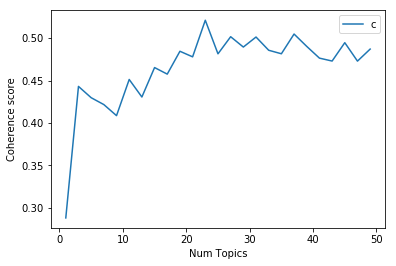

In [63]:
limit=50 
start=1 
step=2
x = range(start, limit, step)
print(x)
print(coherence_values)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()


In [64]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 1  has Coherence Value of 0.2883
Num Topics = 3  has Coherence Value of 0.4431
Num Topics = 5  has Coherence Value of 0.4298
Num Topics = 7  has Coherence Value of 0.4217
Num Topics = 9  has Coherence Value of 0.4087
Num Topics = 11  has Coherence Value of 0.4512
Num Topics = 13  has Coherence Value of 0.4306
Num Topics = 15  has Coherence Value of 0.4653
Num Topics = 17  has Coherence Value of 0.4576
Num Topics = 19  has Coherence Value of 0.4845
Num Topics = 21  has Coherence Value of 0.4779
Num Topics = 23  has Coherence Value of 0.521
Num Topics = 25  has Coherence Value of 0.4814
Num Topics = 27  has Coherence Value of 0.5016
Num Topics = 29  has Coherence Value of 0.4894
Num Topics = 31  has Coherence Value of 0.5012
Num Topics = 33  has Coherence Value of 0.4856
Num Topics = 35  has Coherence Value of 0.4815
Num Topics = 37  has Coherence Value of 0.5047
Num Topics = 39  has Coherence Value of 0.4902
Num Topics = 41  has Coherence Value of 0.4764
Num Topics = 43  ha

If the coherence score seems to keep increasing, it may make better sense to pick the model that gave the highest CV before flattening out. 
<https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda>

Now, the question arises which model should we pick now? One of the good practices is to pick the model, that is giving highest coherence value before flattering out. So that’s why, we will be choosing the model with 25 topics which is at number 4 in the above list.
<https://www.tutorialspoint.com/gensim/gensim_documents_and_lda_model.htm>

In [68]:
## Add the number in the list of the optimal topic number, then print out that number of topics. 
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.046*"hypertension" + 0.013*"anger" + 0.012*"psychological" + '
  '0.010*"control" + 0.010*"pakistan" + 0.009*"al" + 0.008*"blood_pressure" + '
  '0.007*"stress" + 0.007*"case" + 0.007*"gender"'),
 (1,
  '0.022*"obesity" + 0.019*"bmi" + 0.012*"weight" + 0.011*"effect" + '
  '0.009*"overweight" + 0.008*"test" + 0.007*"diet" + 0.007*"patient" + '
  '0.006*"care" + 0.006*"student"'),
 (2,
  '0.021*"patient" + 0.014*"diabetes" + 0.011*"metabolic_syndrome" + '
  '0.010*"cholesterol" + 0.009*"child" + 0.007*"al" + 0.007*"type" + '
  '0.007*"coronary" + 0.006*"triglyceride" + 0.006*"people"')]


### Finding dominant topics in sentences

Finding dominant topics in sentences is one of the most useful practical applications of topic modeling. It determines what topic a given document is about. Here, we will find that topic number which has the highest percentage contribution in that particular document. In order to aggregate the information in a table, we will be creating a function named dominant_topics() 
<https://www.tutorialspoint.com/gensim/gensim_documents_and_lda_model.htm>

In [69]:
def format_topics_sentences(ldamodel=topic_model, corpus=bow_corpus, texts=texts_out_2):
    ## Init output
    sent_topics_df = pd.DataFrame()

    ## Next, we will get the main topics in every document −
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        
        ## Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=bow_corpus, texts=texts_out_2)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.7424,"hypertension, anger, psychological, control, p...","[aggression, physical, health, marry, woman, a..."
1,1,1.0,0.7380,"obesity, bmi, weight, effect, overweight, test...","[impact_socio_demographic, factor, awareness, ..."
2,2,1.0,0.5299,"obesity, bmi, weight, effect, overweight, test...","[health, promoting, factor, lifestyle_nursing_..."
3,3,2.0,0.5915,"patient, diabetes, metabolic_syndrome, cholest...","[effects_app_based_incentives, multinomial_log..."
4,4,2.0,0.6098,"patient, diabetes, metabolic_syndrome, cholest...","[prevalence, dyslipidemia, young, adult, preva..."
5,5,2.0,0.4415,"patient, diabetes, metabolic_syndrome, cholest...","[risk, factor, atherosclerotic, cardiovascular..."
6,6,0.0,0.6755,"hypertension, anger, psychological, control, p...","[gay_community_neo, marginalised_modern_societ..."
7,7,2.0,0.5271,"patient, diabetes, metabolic_syndrome, cholest...","[biological, effect, testosterone_polycystic_o..."
8,8,0.0,0.7816,"hypertension, anger, psychological, control, p...","[determinants_depression_anxiety, stress_left_..."
9,9,2.0,0.6871,"patient, diabetes, metabolic_syndrome, cholest...","[profile, non, fasting, lipid, level, normal, ..."


### Finding Most Representative Document
In order to understand more about the topic, we can also find the documents, a given topic has contributed to the most. We can infer that topic by reading that particular document(s).

In [ ]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

### Topic distribution across documents
Finally, we want to understand the volume and distribution of topics in order to judge how widely it was discussed. The below table exposes that information.

In [ ]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

### Volume & Distribution of Topics
Sometimes we also want to judge how widely the topic is discussed in documents. For this we need to understand the volume and distribution of topics across the documents.

First calculate the number of documents for every Topic as follows −

In [ ]:
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

Next, calculate the percentage of Documents for every Topic as follows −;

In [ ]:
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

Now find the topic Number and Keywords as follows −

In [ ]:
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

Now, concatenate then Column wise as follows −

In [ ]:
df_dominant_topics = pd.concat(
   [topic_num_keywords, topic_counts, topic_contribution], axis=1
)

Next, we will change the Column names as follows −

In [ ]:
df_dominant_topics.columns = [
   'Dominant-Topic', 'Topic-Keywords', 'Num_Documents', 'Perc_Documents'
]
df_dominant_topics

## Apply the Dynamic Topic Model 

Use the Dynamic Topic Model (

In [ ]:
## Run the Gensim Library TFIDF Model 
##The words that will occur more frequently in the document will get the smaller weights.
##https://radimrehurek.com/gensim/auto_examples/core/run_core_concepts.html#sphx-glr-auto-examples-core-run-core-concepts-py
##new_list = []

# tfidf_frequency = []

# def run_gensim_tfidf_model(corpus, dictionary): 
    
#     ##Initialize the tf-idf model, training it on our corpus 
#     tfidf = models.TfidfModel(corpus)
    
#     ##if working with a new document, you can get tfidf from the model
#     #new_doc = "abbott bra adolesc".lower().split()
#     #print(new_doc)
#     #new_list.append(tfidf[dictionary.doc2bow(new_doc)])
    
#     corpus_tfidf = tfidf[corpus]
#     for doc in corpus_tfidf:
#         ##pprint.pprint(doc)
#         tfidf_frequency.append(doc)
    
#     #Print word frequencies by vector 
#     id_words_frequency = [[(dictionary[id], frequency) for id, frequency in line] for line in tfidf_frequency]
#     print("Word Frequency by Vector: ")
#     pprint.pprint(id_words_frequency[2])
    
# run_gensim_tfidf_model(bow_corpus, dictionary)

#pprint.pprint(tfidf_frequency)
    